In [1]:
from typing import Union
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
import sys
logging.basicConfig(level=logging.INFO)

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import matplotlib.pyplot as plt
import seaborn as sns

from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import evalu
from dredFISH.Analysis import TissueGraph as tgh

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(evalu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

In [2]:
logging.info('hi')

INFO:root:hi


# file paths and load data

In [3]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

# dredFISH data
dataset = 'DPNMF_PolyA_2021Nov19' # dataset tag
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
fish_path = f'{base_path}fishdata_2022Mar23/' # Zach's new version
# anndata_path = f'{base_path}results/raw_fishdata_Mar30.h5ad'
anndata_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_results_anndata.h5ad'
# anndata_path = ''

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'
# scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_10x_ctxhippo_a_DPNMF_matrix.h5ad'

# allen tree
allen_tree_path='/bigstore/GeneralStorage/fangming/reference/allen_ccf/structures.json'

In [4]:
%%time
# load dredFISH
TMG = tgh.TissueMultiGraph(name=dataset)
# load raw counts data
if os.path.isfile(anndata_path):
    print('from AnnData')
    TMG.load_from_anndata(anndata_path)
else:
    print('from FishData')
    TMG.load_from_fishdata(fish_path, dataset, output_path=anndata_path)
# normalize (optional for spatial registration)
TMG.normalize_data(norm_cell=True, norm_bit=False)

### for now
data = TMG.data
# print(data)
    
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)

# allen tree
allen_tree, allen_maps = regu.load_allen_tree(allen_tree_path)

from AnnData


INFO:root:113758 cells, minimum counts = 1248.0


CPU times: user 536 ms, sys: 581 ms, total: 1.12 s
Wall time: 2.08 s


In [5]:
# select specific regions
selected_regions = ['Isocortex', 'HPF']
selected_all_sids = regu.expand_regions(allen_tree, selected_regions, 'acronym')

# selected cells
cond_cells = data.obs['region_id'].isin(selected_all_sids)
data = data[cond_cells]
data

View of AnnData object with n_obs × n_vars = 44075 × 24
    obs: 'label', 'pixel_x', 'pixel_y', 'nuclei_size', 'nuclei_signal', 'cytoplasm_size', 'cytoplasm_signal', 'total_size', 'total_signal', 'posname', 'posname_stage_x', 'posname_stage_y', 'cell_name', 'stage_x', 'stage_y', 'coord_x', 'coord_y', 'region_id', 'region_color', 'region_acronym'
    obsm: 'stage'
    layers: 'cytoplasm_vectors', 'nuclei_vectors', 'total_vectors', 'norm_cell'

In [6]:
# prepare
ref_data.obs = ref_data.obs.rename(columns={
    'class_label': 'Level_1_class_label', 
    'neighborhood_label': 'Level_2_neighborhood_label', 
    'subclass_label': 'Level_3_subclass_label', 
    # 'supertype_label', 
    'cluster_label': 'Level_5_cluster_label', 
})

celltype_levels = np.sort(ref_data.obs.filter(regex=r'^Level_[0-9]', axis=1).columns.values)
print(celltype_levels)

levels = celltype_levels[:3]      
X_data = np.array(data.layers['norm_cell'])
X_refdata = np.array(ref_data.X)
Y_refdata = ref_data.obs[levels].values

print(levels, X_data.shape, X_refdata.shape, Y_refdata.shape)

['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label' 'Level_5_cluster_label']
['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label'] (44075, 24) (73347, 24) (73347, 3)


## run -- baseline 
- takes ~8s
- bias towards small cell types

- `KNN` is better at broad cell types (glia vs neurons)
- `SVM (rbf kernel)` is better at PT and PT subtypes

In [7]:
# %%time
# # run # baseline
# importlib.reload(celltypeu)
# output = f"{res_dir}celltypes_baseline_version1_April19.npy"

# # choosing models: they overall performed similar, but each has some unique strengths
# model = KNeighborsClassifier(n_neighbors=15, metric='correlation') # metric 'cosine' is also good
# # model = svm.SVC(kernel='rbf') # # this is also good 


# norm = 'per_bit_equalscale'
# ranknorm = False
# n_cells = 100

# y_data = celltypeu.iterative_classify(
#                  X_refdata,
#                  Y_refdata,
#                  X_data,
#                  levels,
#                  # run_func='run', # baseline
#                  run_func='run', # baseline
#                  run_kwargs_perlevel=[dict(norm=norm, ranknorm=ranknorm, n_cells=n_cells)], 
#                  model=model,
#                  verbose=True,
#                  ignore_internal_failure=False,
# )
# print(output)
# np.save(output, y_data)

## run -- iterative prior
- takes ~5min
- bias towards large cell types
- uncomment to run

In [8]:
# %%time
# # recipe
# importlib.reload(celltypeu)
# output = f"{res_dir}celltypes_iterative_prior_version1_April19.npy"

# norm = 'per_bit_equalscale'
# ranknorm = False
# model = KNeighborsClassifier(n_neighbors=15, metric='correlation')

# run_kwargs_perlevel = [
#     dict(overall_sample_fraction=0.1, # as large as possible, but should allow wiggle room to adjust sampled composition
#         min_total_cells=100,
#         min_cells=20, # should be > n_neighbors in kNN algorithm
#         p0 = 0.5,
#         norm=norm,
#         ranknorm=ranknorm,
#         subrun_func='run',
#         ),
    
#     dict(overall_sample_fraction=0.4, # as large as possible, but should allow wiggle room to adjust sampled composition
#         min_total_cells=100,
#         min_cells=20, # should be > n_neighbors in kNN algorithm
#         p0 = 0.5,
#         norm=norm,
#         ranknorm=ranknorm,
#         subrun_func='run',
#         ),
    
#     dict(overall_sample_fraction=0.8, # as large as possible, but should allow wiggle room to adjust sampled composition
#         min_total_cells=100,
#         min_cells=20, # should be > n_neighbors in kNN algorithm
#         p0 = 0.5,
#         norm=norm,
#         ranknorm=ranknorm,
#         subrun_func='run',
#         ),
# ]

# levels = celltype_levels[:3]

# y_data = celltypeu.iterative_classify(
#                  X_refdata,
#                  Y_refdata,
#                  X_data,
#                  levels,
#                  run_func='run_iterative_prior', # 
#                  # run_func='run', # 
#                  run_kwargs_perlevel=run_kwargs_perlevel,
#                  model=model,
#                  ignore_internal_failure=False,
#                  verbose=True,
# )

# print(output)
# np.save(output, y_data)

# Evaluate and save 

In [9]:
# # for evaluations
# input_embed1 = f'{res_dir}Joint_UMAP_isocortex_hpf_April1.csv'
# print(input_embed1)
# input_embed2 = f'{res_dir}Joint_UMAP_isocortex_hpf_subsamp100_level1_April1.csv'
# print(input_embed2)

# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'

In [10]:
# analysis
with open(meta_path, 'r') as fh:
    meta = json.load(fh)

In [16]:
# f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_baseline_version1_April19.npy"
f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_iterative_prior_version1_April19.npy"
fout = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_iterative_prior_version1_April19.csv"
# f = output
print(f)

y_data = np.load(f, allow_pickle=True)
res = data.obs.copy() #pd.DataFrame(index=data.obs.index)
for i, level in enumerate(levels):
    res[level] = y_data[:,i]
res

/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_iterative_prior_version1_April19.npy


,label,pixel_x,pixel_y,nuclei_size,nuclei_signal,cytoplasm_size,cytoplasm_signal,total_size,total_signal,posname,...,stage_x,stage_y,coord_x,coord_y,region_id,region_color,region_acronym,Level_1_class_label,Level_2_neighborhood_label,Level_3_subclass_label
DPNMF_PolyA_2021Nov19_Pos3_cell_1.0,1.0,6.946154,13.064102,390.0,37376.0,94.0,26496.0,479.0,35312.0,Pos3,...,-2412.264446,-3414.258897,-3836.669362,257.071979,366,#15B0B3,TEa6a,Glutamatergic,NP/CT/L6b,L6 CT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_2.0,2.0,11.731343,96.792404,737.0,36368.0,146.0,26160.0,873.0,34224.0,Pos3,...,-2413.824418,-3441.554324,-3864.007917,257.349850,366,#15B0B3,TEa6a,Glutamatergic,NP/CT/L6b,L6 CT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_3.0,3.0,8.584210,230.557892,380.0,42064.0,132.0,34464.0,390.0,38992.0,Pos3,...,-2412.798453,-3485.161873,-3907.519336,254.279457,365,#15B0B3,TEa5,Glutamatergic,L4/5/6 IT Car3,L4/5 IT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_5.0,5.0,7.058411,385.787384,428.0,46496.0,143.0,39760.0,566.0,45040.0,Pos3,...,-2412.301042,-3535.766687,-3958.045112,251.408807,365,#15B0B3,TEa5,Glutamatergic,L4/5/6 IT Car3,Car3
DPNMF_PolyA_2021Nov19_Pos3_cell_7.0,7.0,9.555555,576.148865,477.0,6816.0,19.0,6400.0,475.0,6832.0,Pos3,...,-2413.115111,-3597.824530,-4020.072828,249.310951,365,#15B0B3,TEa5,Non-Neuronal,Other,SMC-Peri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DPNMF_PolyA_2021Nov19_Pos102_cell_1351.0,1351.0,2025.603882,2292.653809,260.0,7744.0,220.0,8176.0,474.0,7888.0,Pos102,...,-409.346865,2777.594858,2442.321904,-1453.191293,463,#7ED04B,CA2,Non-Neuronal,Other,Astro
DPNMF_PolyA_2021Nov19_Pos102_cell_1352.0,1352.0,2031.969238,2012.783447,651.0,7664.0,114.0,7024.0,651.0,7248.0,Pos102,...,-411.421972,2868.832596,2533.361867,-1446.838662,463,#7ED04B,CA2,Non-Neuronal,Other,Oligo
DPNMF_PolyA_2021Nov19_Pos102_cell_1353.0,1353.0,2031.924072,2435.701660,382.0,4432.0,126.0,4672.0,508.0,4560.0,Pos102,...,-411.407248,2730.961259,2395.642989,-1453.320683,463,#7ED04B,CA2,Non-Neuronal,Other,Oligo
DPNMF_PolyA_2021Nov19_Pos102_cell_1356.0,1356.0,2033.539062,2311.605469,256.0,8960.0,367.0,9360.0,629.0,9184.0,Pos102,...,-411.933734,2771.416617,2436.029118,-1450.897083,463,#7ED04B,CA2,Non-Neuronal,Other,Oligo


In [18]:
print(fout)
res.filter(regex=f'^Level_[0-9]', axis=1).to_csv(fout, header=True, index=True)
!head $fout

/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_iterative_prior_version1_April19.csv
,Level_1_class_label,Level_2_neighborhood_label,Level_3_subclass_label
DPNMF_PolyA_2021Nov19_Pos3_cell_1.0,Glutamatergic,NP/CT/L6b,L6 CT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_2.0,Glutamatergic,NP/CT/L6b,L6 CT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_3.0,Glutamatergic,L4/5/6 IT Car3,L4/5 IT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_5.0,Glutamatergic,L4/5/6 IT Car3,Car3
DPNMF_PolyA_2021Nov19_Pos3_cell_7.0,Non-Neuronal,Other,SMC-Peri
DPNMF_PolyA_2021Nov19_Pos3_cell_8.0,GABAergic,MGE,Sst
DPNMF_PolyA_2021Nov19_Pos3_cell_9.0,Non-Neuronal,Other,SMC-Peri
DPNMF_PolyA_2021Nov19_Pos3_cell_10.0,Glutamatergic,L4/5/6 IT Car3,L4/5 IT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_11.0,Glutamatergic,L2/3 IT,L2/3 IT PPP


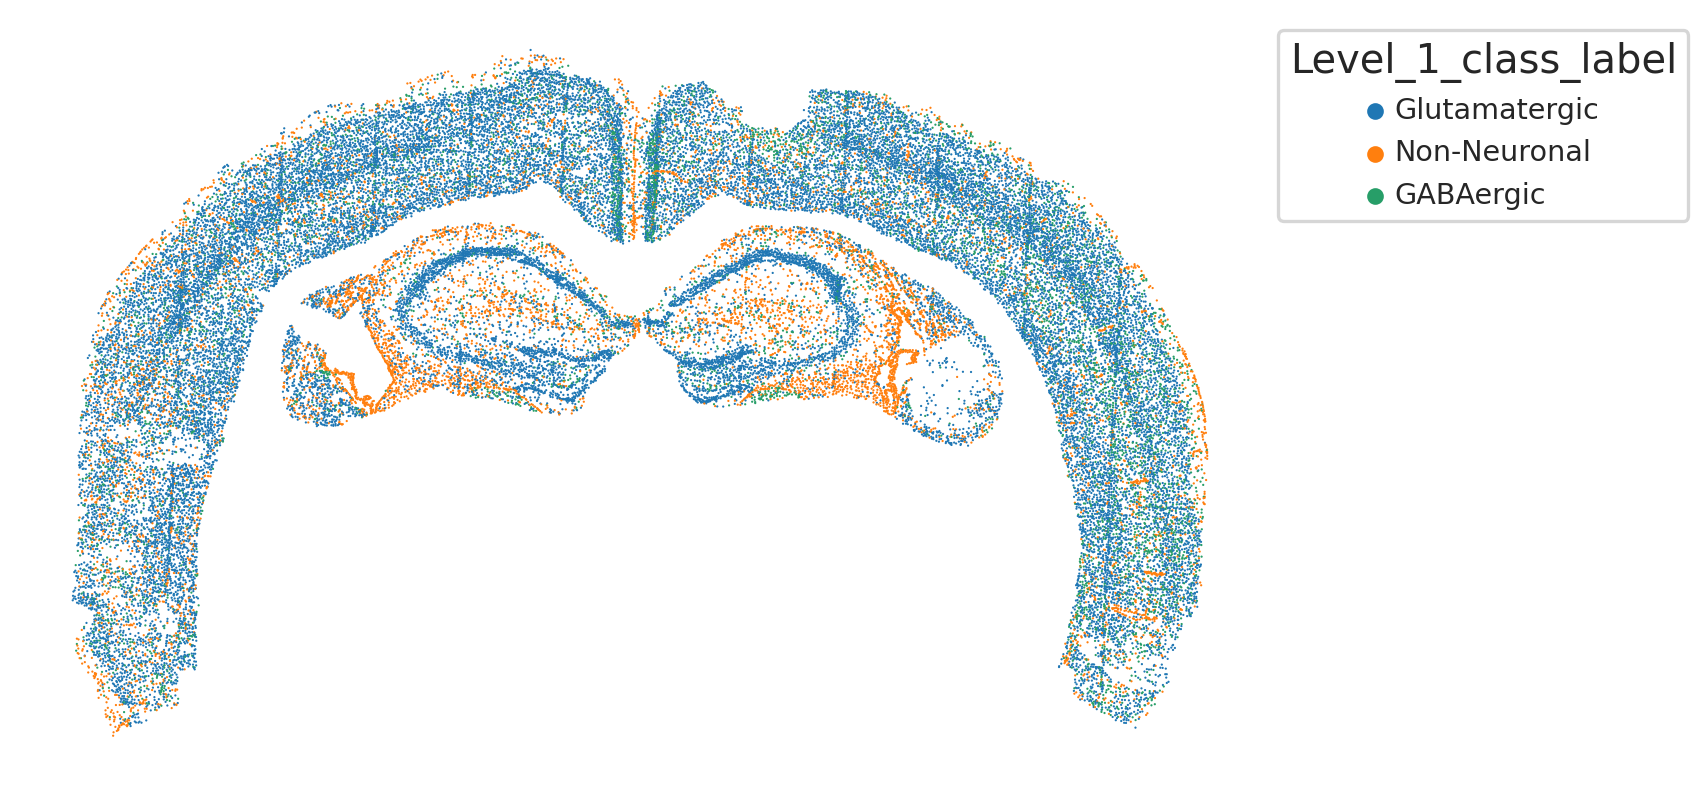

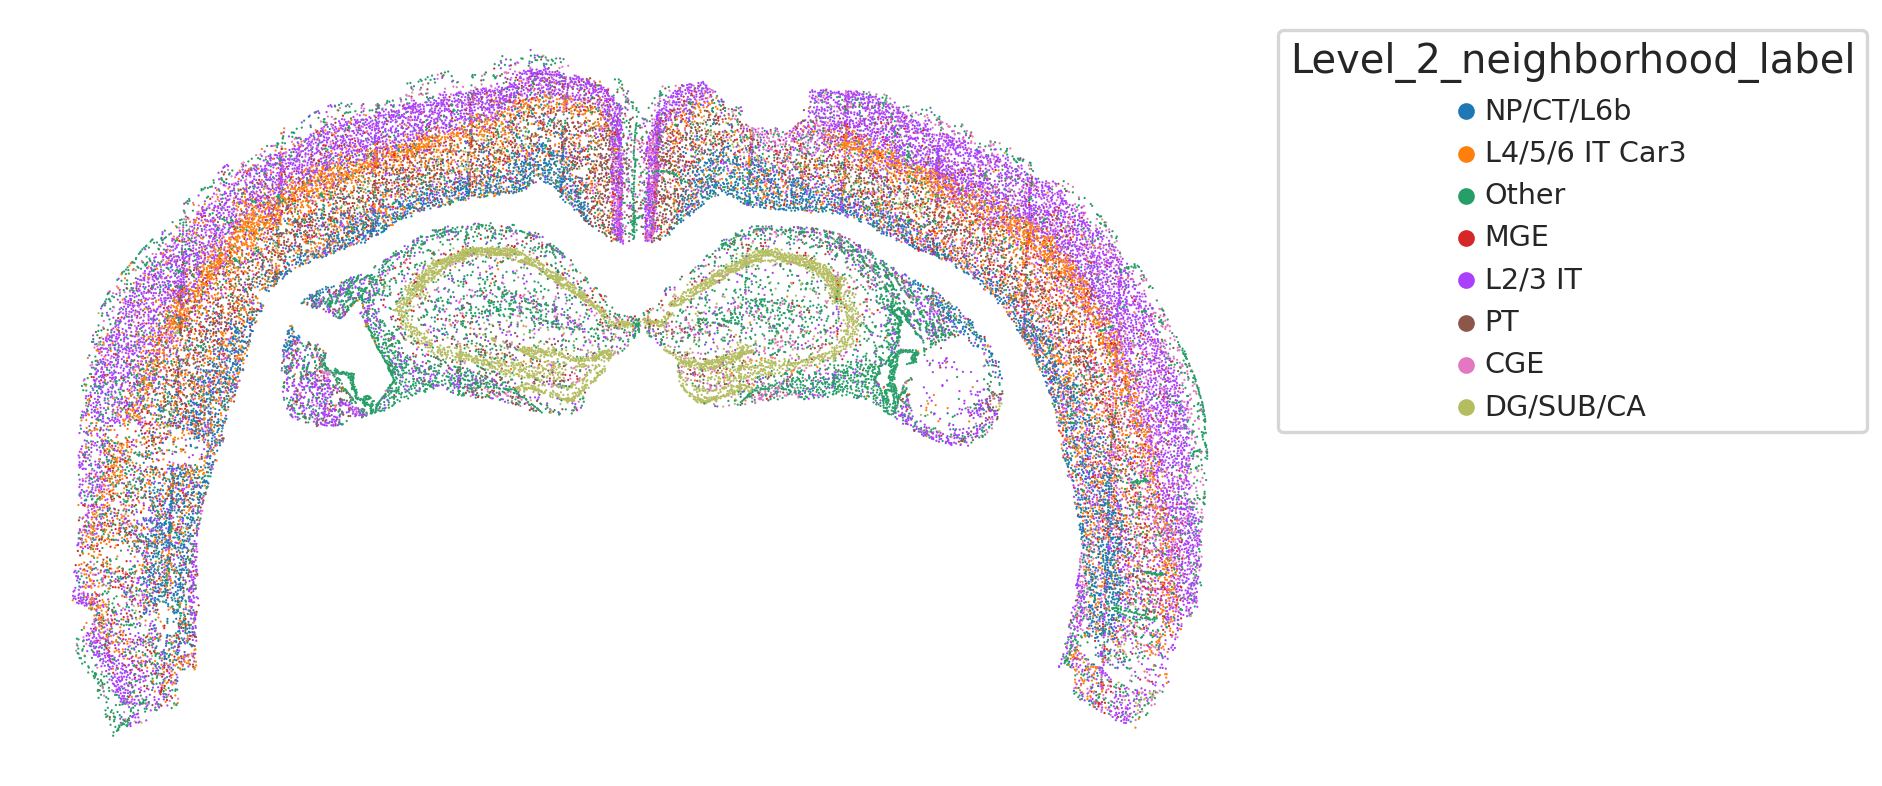

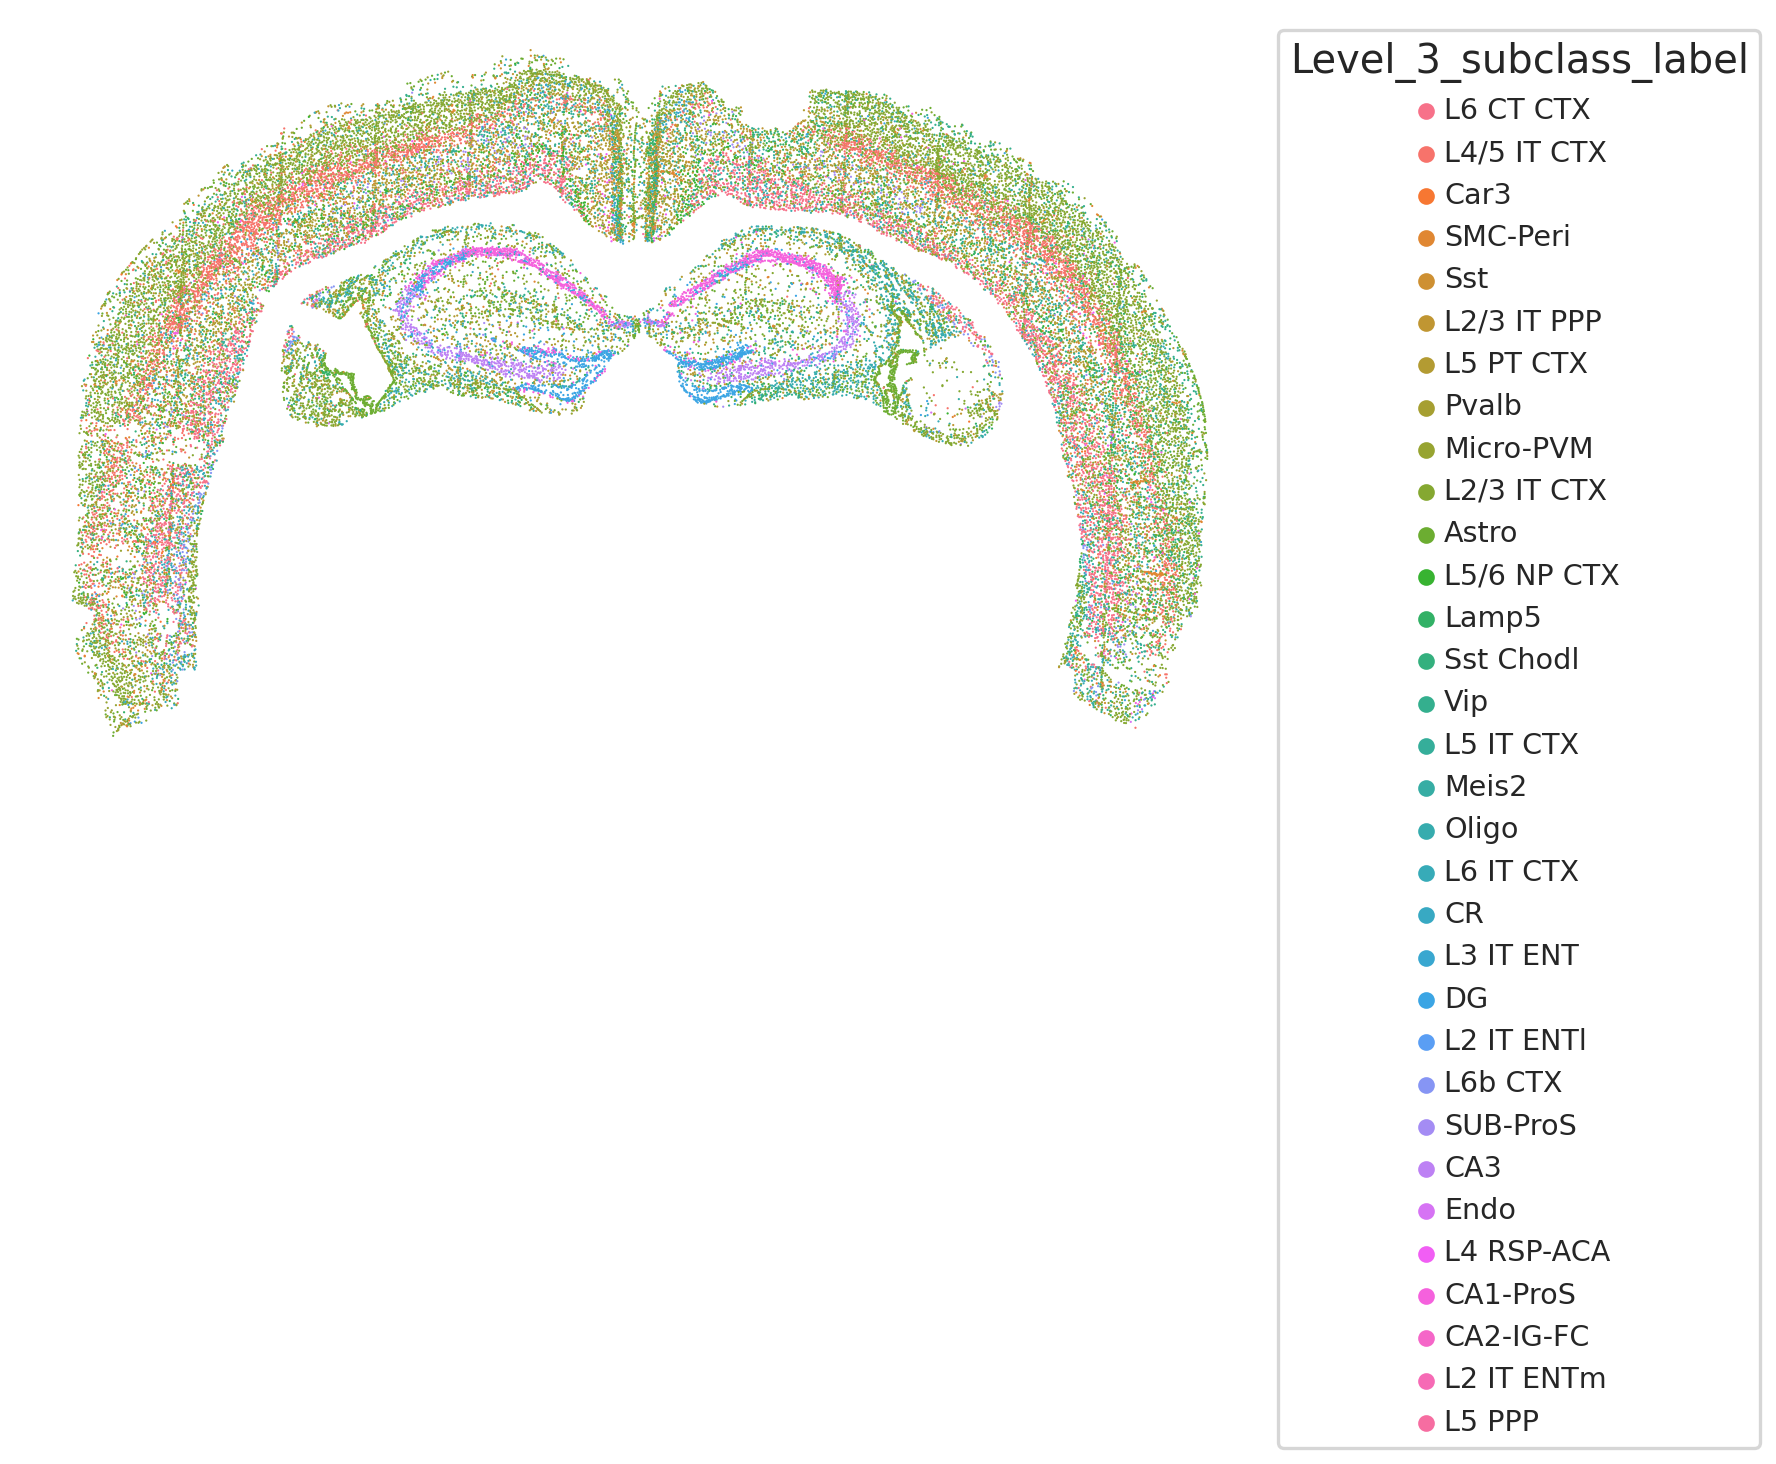

In [12]:
for level in levels:
    fig, ax = plt.subplots(figsize=(10,8))
    sns.scatterplot(data=res, x='coord_x', y='coord_y', hue=level,
                    # hue_order=np.sort(np.unique(res[level])),
                    s=1,
                    edgecolor='none',
                    rasterized=True,
                   )
    ax.axis('off')
    ax.legend(bbox_to_anchor=(1,1), 
              loc='upper left', 
              # ncol=1+int(len(np.unique(res[level]))/20), 
              title=level,
             )
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.show()